# **Physics Informed Neural Networks (PINN): Demonstration**

This work is a demonstration of implementing PINN from scratch using Pytorch in order to learn the solutions of a generalized Lindblad master equation.

Resources:

* [Pytorch tutorial](https://youtu.be/Z_ikDlimN6A?si=WI4p53bMW2Fui7F2)
* [ETH Zurich: AI in Sciences and Engineering](https://youtube.com/playlist?list=PLJkYEExhe7rYFkBIB2U5pf_RWzYnFLj7r&si=DibkHphi6pFczmoz)

In [76]:
import torch
import torch.nn as nn
from torch import pi, sin, cos, exp, sqrt
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import colormaps as cm
import plotly.graph_objects as go
from tqdm import tqdm

In [77]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Problem overview

Here we shall implement PINN to study the **generalized Lindblad master equation** that describes population transfer from ground state to exciton state in a two-level quantum system coupled to a acoustic-phonon bath.






We are interested in modelling the coordinates of the tip of the quantum state vector inside the Bloch sphere with passage of time.


Denote by **s**(t) = $[s_x(t), s_y(t), s_z(t)]$ the instantaneous Bloch vector components with the initial boundary conditions as $s_x(0) = s_y(0) = 0, s_z(0) = -1/2$.  

The evolution of **s** (denoting the quantum dot density matrix) is governed by the following set of differential equations:

$\hspace{3cm}\dot{s_x} = - \frac{\Omega}{\Lambda}(\gamma_a - \gamma_e) - \frac{\Delta^2+2\Omega^2}{2\Lambda^2}(\gamma_a + \gamma_e)s_x - Δs_y + \frac{\Delta\Omega}{2\Lambda^2}(\gamma_a + \gamma_e)s_z \\
\hspace{3cm}\dot{s_y} = \Delta s_x - \frac{\gamma_a + \gamma_e}{2} s_y + \Omega s_z \\
\hspace{3cm}\dot{s_z} = \frac{\Delta}{\Lambda}(\gamma_a - \gamma_e) + \frac{\Delta\Omega}{2\Lambda^2}(\gamma_a + \gamma_e)s_x - \Omega s_y - \frac{2\Delta^2+\Omega^2}{2\Lambda^2}(\gamma_a + \gamma_e)s_z$

where,
$\Lambda = \sqrt{\Omega^2 + \Delta^2}$ denotes the instantaneoues eigenstate splitting, and the phonon absorption and emission rates are given by

$\hspace{5cm}\gamma_a = 2 \left(\frac{\Omega}{2\Lambda} \right)^2 \pi J(\Lambda) n_b(\Lambda) \\
\hspace{5cm}\gamma_e = 2 \left(\frac{\Omega}{2\Lambda} \right)^2 \pi J(\Lambda) [1 + n_b(\Lambda)]$

Here,

$J(\omega) = \frac{\hbar A}{\pi k_B}\omega^3 e^{-\omega^2/\omega_c^2}$ represents the super-Ohmic spectral density, and $n_b(\omega) = 1/[e^{\hbar \omega / k_B \Theta} - 1]$ represents the phonon occupation number

at frequency $\omega$ and temperature $\Theta$.

The Rabi frequency $\Omega(t)$ and the detuning $\Delta(t)$ are derived using methods from Shortcuts to Adiabaticity and under suitable transformations they can be expressed as

$\hspace{5cm}\Omega(t) = \sqrt{E_0^2 \sin^2\theta + \dot{\theta}^2} \\
\hspace{5cm}\Delta(t) = \frac{E_0^3 \sin^2\theta \cos\theta + \dot{E}_0\sin\theta + E_0({2\ddot{\theta}\cos\theta - \dot{\theta}^2\sin\theta)}}{E_0^2 \sin^2\theta + \dot{\theta}^2}$

where, the time-dependent amplitude $E_0(\tau)$ and the mixing angle $\theta(\tau)$ are given by ($\tau$ refers to the scaled time unit, $\tau = t/D$),

$\hspace{6cm}E_0(\tau) = \Omega_0\tau(1-\tau) \\
\hspace{6cm}\theta(\tau) = \pi \tau^2(3-2\tau)$

## Workflow overview

* First, we shall compute the exact numerical solutions to these differential equations using *solve_ivp()* function from *scipy* library

* **Task 1: Simulation**

    Train a PINN to learn the above dynamics by only specifying the differential equations and the initial boundary conditions.

    *F(a)* = ***b***

* **Task 2: Inverse Problem**

    Given the initial boundary conditions, a few or all of the trajectory points of the dynamics, and the set of differential equations but only partially, i.e. the mixing angle $\theta(t)$ is unknown, can the PINN discover the underlying $\theta(t)$ which generates the specified dynamics?

    *F(****a****)* = *b*

In [137]:
# Specify the physical constants

hbar = torch.tensor(1.054571817e-22, device=device)      # J*ps
A = torch.tensor(0.0112, device=device)                  # ps/K
kb = torch.tensor(1.380649e-23, device=device)           # SI
v_c = torch.tensor(3, device=device)                     # 1/ps
T = torch.tensor(10, device=device)                      # K
D = torch.tensor(3, device=device)                       # ps
Om_0 = torch.tensor(1, device=device)                    # 1/ps

In [138]:
# Define the various functions mentioned above

# time-dependent amplitude
def amp(t,D,Om_0):
    s = t/D
    return Om_0 * s * (1-s)

# first derivative of amplitude
def amp_dot(t,D,Om_0):
    s = t/D
    return Om_0 * (1-2*s) / D

# mixing angle
def mixangle(t,D):
    s = t/D
    return pi * s**2 * (3 - 2*s)

# first derivative of mixing angle
def mixangle_dot(t,D,how='s'):
    s = t/D
    if how == 's':
        return 6 * pi * s * (1 - s) / D
    else:
        return 12 * pi * s * (1 - s)**2 / D

# double derivative of mixingle angle
def mixangle_2dot(t,D,how='s'):
    s = t/D
    if how == 's':
        return 6 * pi * (1 - 2*s) / D**2
    else:
        return 12 * pi * (1 - 3*s) * (1 - s) / D**2

# time-dependent Rabi frequency
def rabi_freq(t,D,Om_0,how='s'):
    '''
     time-dependent amplitude Ω~(t)  of the applied field
     t: time in ps
     D: pulse duration in ps
     Om_0: amplitude of the applied field
     how: 's' for symmetric, 'ns' for non-symmetric
    '''
    return sqrt((amp(t=t,D=D,Om_0=Om_0)*sin(mixangle(t=t,D=D)))**2 + mixangle_dot(t=t,D=D,how=how)**2)

# time-dependent detuning
def detuning(t,D,Om_0,how='s'):
    '''
     time-dependent  chirp (t)  of the applied field
     t: time in ps
     D: pulse duration in ps
     Om_0: amplitude of the applied field
     how: 's' for symmetric, 'ns' for non-symmetric
    '''
    #s = lambda t: t/D
    eps = 1e-10
    E = amp(t=t,D=D,Om_0=Om_0)
    E_dot = amp_dot(t=t,D=D,Om_0=Om_0)
    angle = mixangle(t=t,D=D)
    angle_dot = mixangle_dot(t=t,D=D,how=how)
    angle_2dot = mixangle_2dot(t=t,D=D,how=how)

    return (E**3*sin(angle)**2*cos(angle) + E_dot*angle_dot*sin(angle) + E*(2*angle_dot**2*cos(angle) - angle_2dot*sin(angle)))/((E*sin(angle))**2 + angle_dot**2 + eps)

# eigenstate splitting
def eig_split(om,delta):
    return sqrt(om**2 + delta**2)

# spectral density
def spec_dens(v):
    return hbar*A / (pi*kb) * v**3 * exp(-(v/v_c)**2)

# phonon occupation number
def phonon_occ(v):
    eps = 1e-9
    return 1 / ((exp(hbar*v/(kb*T)) - 1) + eps)

# phonon absorption rate
def phonon_abs(v, theta):
    return 2 * (cos(theta)/2)**2 * pi * spec_dens(v) * phonon_occ(v)

# phonon emission rate
def phonon_emiss(v, theta):
    return 2 * (cos(theta)/2)**2 * pi * spec_dens(v) * (1+phonon_occ(v))

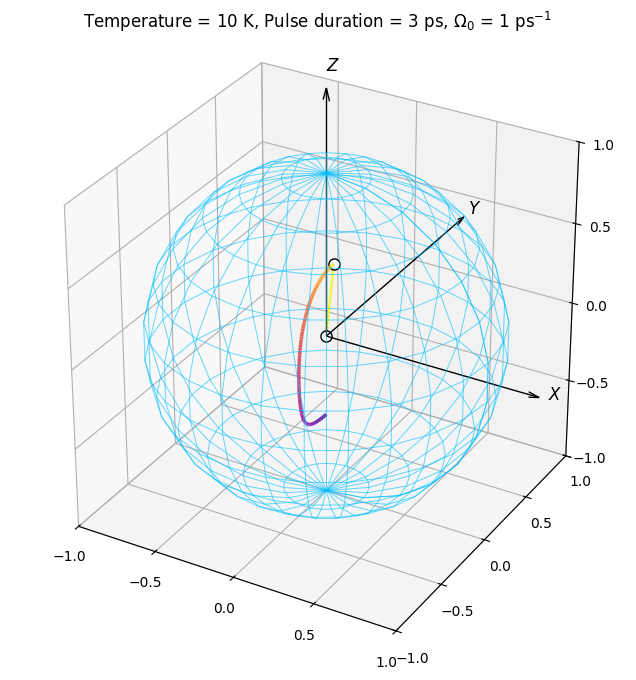

In [44]:
# Bloch equations representing Lindblad master equation
def bloch_eqs(t, S, D, Om_0):

    sx, sy, sz = S
    eps = 1e-10
    om = rabi_freq(t=t,D=D,Om_0=Om_0)
    delta = detuning(t=t,D=D,Om_0=Om_0)
    theta = mixangle(t=t,D=D)
    L = eig_split(om,delta) + eps
    ga = phonon_abs(v=L, theta=theta)
    ge = phonon_emiss(v=L, theta=theta)

    dsx_dt = - om*(ga-ge)/L - (delta**2 + 2*om**2)*(ga+ge)*sx/(2*L**2) - delta*sy + delta*om*(ga+ge)*sz/(2*L**2)
    dsy_dt = delta*sx - (ga+ge)*sy/2 + om*sz
    dsz_dt = delta*(ga-ge)/L + delta*om*(ga+ge)*sx/(2*L**2) - om*sy - (2*delta**2+om**2)*(ga+ge)*sz/(2*L**2)

    return torch.tensor([dsx_dt, dsy_dt, dsz_dt])

# Time evolution parameters
t_intervals = 150
t_span = (0, D)  # Start to end time
t_eval = torch.linspace(t_span[0], t_span[1], t_intervals)  # Time points

# Initial Bloch vector (example: starts along -z-axis)
S0 = torch.tensor([0.0, 0.0, -0.5])

# Solve the equations numerically
sol = solve_ivp(bloch_eqs, t_span, S0, t_eval=t_eval, args=(D,Om_0))
sx, sy, sz = sol.y

# Create figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Draw Bloch sphere with fine longitudes and latitudes
u = np.linspace(0, 2 * np.pi, 28)
v = np.linspace(0, np.pi, 14)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='deepskyblue', alpha=0.6, linewidth=0.7)

# Draw XYZ axes
arrow_length = 1.5
ax.quiver(0, 0, 0, 1.3, 0, 0, color="black", linewidth=1,arrow_length_ratio=0.05)  # X-axis
ax.quiver(0, 0, 0, 0, 1.6, 0, color="black", linewidth=1, arrow_length_ratio=0.05)  # Y-axis
ax.quiver(0, 0, 0, 0, 0, arrow_length, color="black", linewidth=1, arrow_length_ratio=0.05)  # Z-axis

# Axis labels
ax.text(1.35, 0, 0, r"$X$", color='black', fontsize=12, fontweight='bold')
ax.text(0, 1.65, 0, r"$Y$", color='black', fontsize=12, fontweight='bold')
ax.text(0, 0, 1.6, r"$Z$", color='black', fontsize=12, fontweight='bold')


ax.set_box_aspect([1,1,1])  # Maintain equal aspect ratio
ax.grid(True)
ax.set_xticks([-1,-0.5,0,0.5,1])
ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_zticks([-1,-0.5,0,0.5,1])
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
#ax.set_frame_on(False)  # Remove background

ax.title.set_text(f'Temperature = {T} K, Pulse duration = {D} ps, $\Omega_0$ = {Om_0} ps$^{{-1}}$')

# Create a gradient trajectory (VIBGYOR colormap)
points = np.array([sx, sy, sz]).T.reshape(-1, 1, 3)  # Convert to shape (N, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)  # Create line segments
cmap = plt.get_cmap("plasma")
colors = cmap(np.linspace(0, 1, len(t_eval)))

# Plot gradient trajectory
lc = Line3DCollection(segments, colors=colors, linewidth=2.5)
ax.add_collection(lc)

# Initialize Bloch vector (animated)
vector, = ax.plot([], [], [], 'o-', markersize=8, markeredgecolor='black', markerfacecolor='white')

# Update function for animation
def update(frame):
    color = colors[frame]  # Get color from gradient
    vector.set_data([0, sx[frame]], [0, sy[frame]])
    vector.set_3d_properties([0, sz[frame]])
    vector.set_color(color)  # Change Bloch vector color dynamically
    return vector,

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(t_eval), interval=50, blit=True)

# Save as GIF
ani.save("bloch_vector.gif", writer="pillow", fps=20)

# Show plot (optional)
plt.show()

In [ ]:
# Generate colors for trajectory
cmap = cm.get_cmap("plasma")
colors = [f"rgb({int(r*255)},{int(g*255)},{int(b*255)})" for r, g, b, _ in cmap(np.linspace(0, 1, len(t_eval)))]

# Create Bloch sphere grid (wireframe)
u = np.linspace(0, 2 * np.pi, 24)  # Longitude
v = np.linspace(0, np.pi, 12)      # Latitude
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

# Create figure
fig = go.Figure()

# Add Bloch sphere grid lines
for i in range(len(u)):  # Longitude lines
    fig.add_trace(go.Scatter3d(x=x[i, :], y=y[i, :], z=z[i, :], mode="lines", line=dict(color="gray", width=1), showlegend=False))
for j in range(len(v)):  # Latitude lines
    fig.add_trace(go.Scatter3d(x=x[:, j], y=y[:, j], z=z[:, j], mode="lines", line=dict(color="gray", width=1), showlegend=False))

# Add XYZ axes
fig.add_trace(go.Cone(x=[1.2], y=[0], z=[0], u=[1], v=[0], w=[0], sizemode="absolute", sizeref=0.1, colorscale=[[0, "red"], [1, "red"]], showscale=False))
fig.add_trace(go.Cone(x=[0], y=[1.2], z=[0], u=[0], v=[1], w=[0], sizemode="absolute", sizeref=0.1, colorscale=[[0, "green"], [1, "green"]], showscale=False))
fig.add_trace(go.Cone(x=[0], y=[0], z=[1.2], u=[0], v=[0], w=[1], sizemode="absolute", sizeref=0.1, colorscale=[[0, "blue"], [1, "blue"]], showscale=False))

fig.add_trace(go.Scatter3d(x=[0, 1.2], y=[0, 0], z=[0, 0], mode="lines", line=dict(color="red", width=5), name="X-axis"))
fig.add_trace(go.Scatter3d(x=[0, 0], y=[0, 1.2], z=[0, 0], mode="lines", line=dict(color="green", width=5), name="Y-axis"))
fig.add_trace(go.Scatter3d(x=[0, 0], y=[0, 0], z=[0, 1.2], mode="lines", line=dict(color="blue", width=5), name="Z-axis"))

# Add trajectory with gradient color
for i in range(len(t_eval) - 1):
    fig.add_trace(go.Scatter3d(
        x=[sx[i], sx[i+1]], y=[sy[i], sy[i+1]], z=[sz[i], sz[i+1]],
        mode="lines", line=dict(color=colors[i], width=5),
        showlegend=False
    ))

# Add animated Bloch vector
vector = go.Scatter3d(
    x=[0, sx[0]], y=[0, sy[0]], z=[0, sz[0]],
    mode="lines+markers",
    marker=dict(size=4, color="white", line=dict(color="black", width=3)),
    line=dict(color=colors[0], width=8),
    name="Bloch Vector"
)
fig.add_trace(vector)

# Create animation frames
frames = [
    go.Frame(
        data=[
            go.Scatter3d(x=[0, sx[i]], y=[0, sy[i]], z=[0, sz[i]],
                         mode="lines+markers",
                         marker=dict(size=4, color="white", line=dict(color="black", width=2)),
                         line=dict(color=colors[i], width=4))
        ]
    ) for i in range(len(t_eval))
]

fig.frames = frames

# Update layout for interactivity
fig.update_layout(
    title="Interactive Bloch Sphere",
    scene=dict(
        xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False),
        aspectmode="cube"
    ),
    updatemenus=[dict(
        type="buttons",
        showactive=False,
        buttons=[dict(label="Play",
                      method="animate",
                      args=[None, dict(frame=dict(duration=50, redraw=True), fromcurrent=True)])]
    )],
)

# Show interactive plot
fig.show()

# Task 1:

**Given the differential equations and the boundary conditions, can a PINN learn the solutions of the Lindblad master equations?**

### Approach

The PINN is trained to directly approximate the solution to the differential equation i.e.

$\hspace{6cm}NN(t,\mathbf{w}) \approx \mathbf{s}(t)$

over the time range [0, D (pulse duration)]

### Defining the Loss

To simulate the two-level quantum dot system, the PINN is trained with the following loss function

$\hspace{6cm} \mathcal{L}(\mathbf{w}) = \mathcal{L}_{boundary} + \mathcal{L}_{physics}$

where,

$\mathcal{L}_{boundary} = \frac{1}{3}[(NN(0,\mathbf{w})[0] - 0)^2 + (NN(0,\mathbf{w})[1] - 0)^2 + (NN(0,\mathbf{w})[2] + 0.5)^2]$

$\mathcal{L}_{physics} = \frac{1}{3}[\frac{\lambda_1}{N} \sum_{i=1}^N(\frac{d}{dt}NN(t_i,\mathbf{w})[0] + \frac{\Omega}{\Lambda}(\gamma_a - \gamma_e) + \frac{\Delta^2+2\Omega^2}{2\Lambda^2}(\gamma_a + \gamma_e)NN(t_i,\mathbf{w})[0] + ΔNN(t_i,\mathbf{w})[1] - \frac{\Delta\Omega}{2\Lambda^2}(\gamma_a + \gamma_e)NN(t_i,\mathbf{w})[2])^2 \\
\hspace{2cm}+\frac{\lambda_1}{N} \sum_{i=1}^N(\frac{d}{dt}NN(t_i,\mathbf{w})[1] - \Delta NN(t_i,\mathbf{w})[0] + \frac{\gamma_a + \gamma_e}{2} NN(t_i,\mathbf{w})[1] - \Omega NN(t_i,\mathbf{w})[2])^2 \\
\hspace{1.25cm}+\frac{\lambda_1}{N} \sum_{i=1}^N(\frac{d}{dt}NN(t_i,\mathbf{w})[2] - \frac{\Delta}{\Lambda}(\gamma_a - \gamma_e) - \frac{\Delta\Omega}{2\Lambda^2}(\gamma_a + \gamma_e)NN(t_i,\mathbf{w})[0] + \Omega NN(t_i,\mathbf{w})[1] +\frac{2\Delta^2+\Omega^2}{2\Lambda^2}(\gamma_a + \gamma_e)NN(t_i,\mathbf{w})[2])^2]$



### Computing gradients

To compute gradients of the neural network with respect to its inputs, we will use $torch.autograd.grad()$

In [45]:
# Define the architecture of the PINN : a fully connected NN

class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

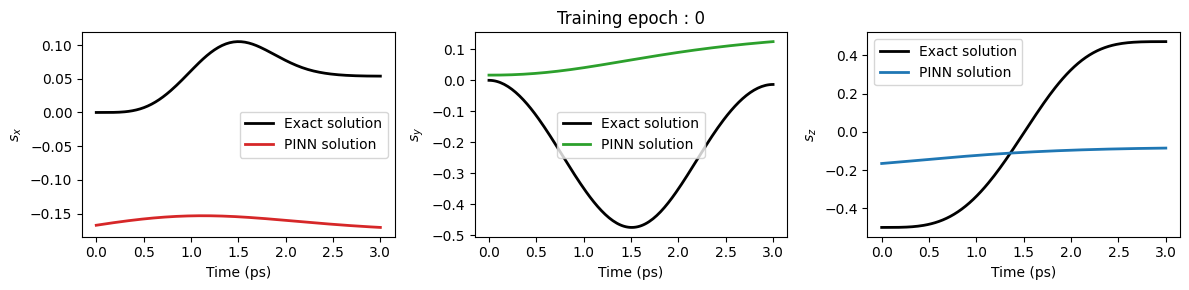

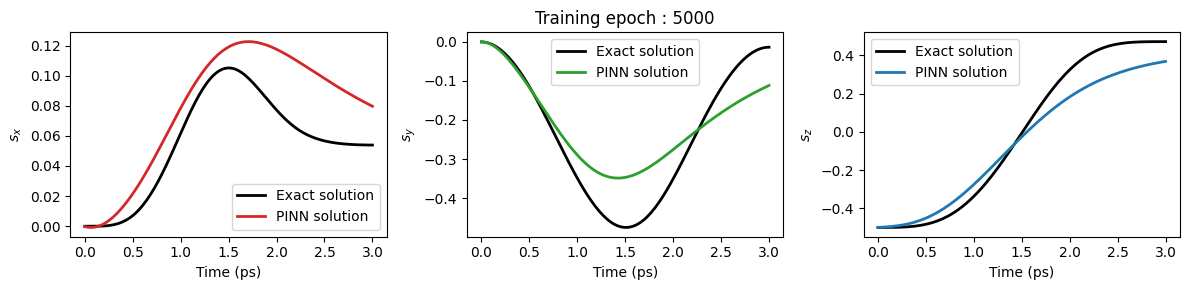

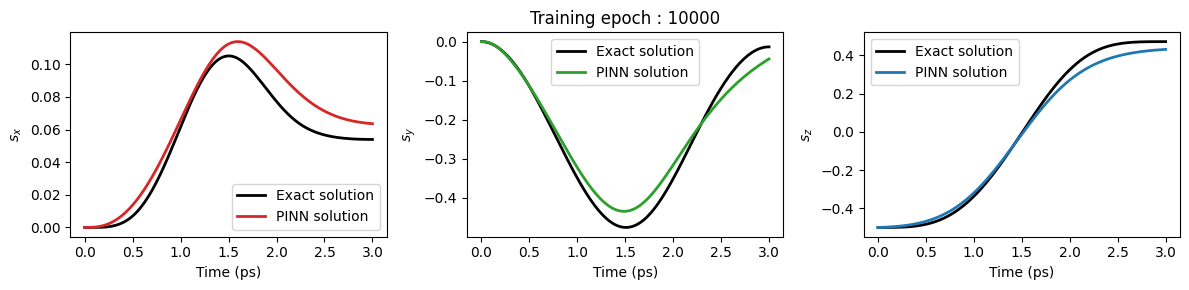

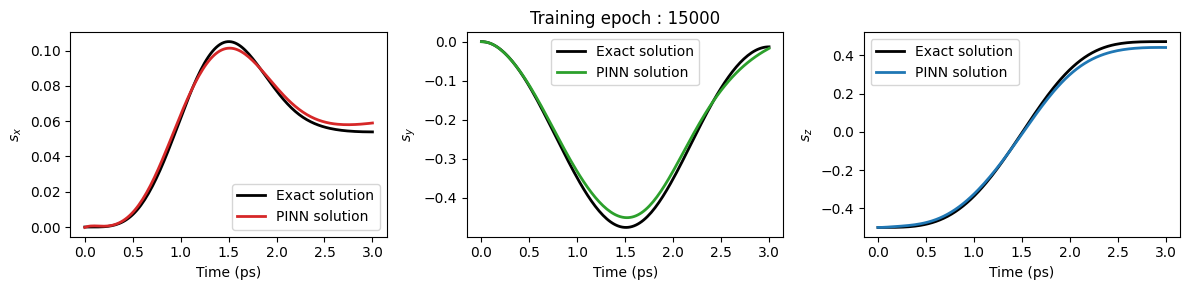

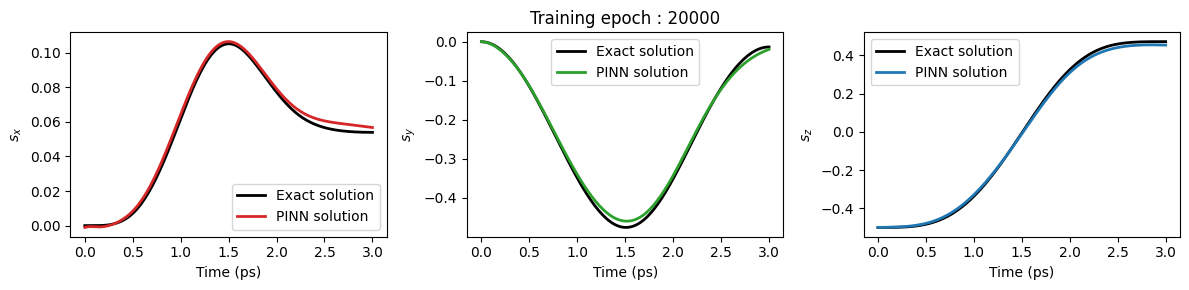

In [8]:
torch.manual_seed(2025)

eps = 1e-10
t_intervals = 150
lambda1 = 1e-3  # regularization hyperparameter
t_test = torch.linspace(0,D,t_intervals).view(-1,1)

# define a neural network that takes one input (t) and outputs three Bloch vector components sx(t), sy(t) and sz(t)
pinn = FCN(1,3,32,4)

# define boundary points, for the boundary loss
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)   # (1,1)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,D,t_intervals).view(-1,1).requires_grad_(True)     # (t_intervals, 1)

# compute the coefficients
rabi_list = rabi_freq(t=t_physics,D=D,Om_0=Om_0)
detuning_list = detuning(t=t_physics,D=D,Om_0=Om_0)
L_list = sqrt(rabi_list**2 + detuning_list**2) + eps
theta_list = mixangle(t=t_physics,D=D)
ga_list = phonon_abs(v=L_list, theta=theta_list)
ge_list = phonon_emiss(v=L_list, theta=theta_list)

# train the pinn
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)

for i in range(20001):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above

    # compute boundary loss
    s0_pred = pinn(t_boundary)
    sx0_pred, sy0_pred, sz0_pred = s0_pred[:,0].view(-1,1), s0_pred[:,1].view(-1,1), s0_pred[:,2].view(-1,1)           # (1, 3)
    loss_b = torch.mean(sx0_pred**2 + sy0_pred**2 + (sz0_pred + 0.5)**2)


    # compute physics loss
    s_pred = pinn(t_physics)     # (t_intervals, 3)
    sx_pred, sy_pred, sz_pred = s_pred[:,0].view(-1,1), s_pred[:,1].view(-1,1), s_pred[:,2].view(-1,1)

    # compute gradients for sx, sy and sz
    dsx_dt = torch.autograd.grad(sx_pred, t_physics, torch.ones_like(sx_pred), create_graph=True)[0]        # (t_intervals, 1)
    dsy_dt = torch.autograd.grad(sy_pred, t_physics, torch.ones_like(sy_pred), create_graph=True)[0]        # (t_intervals, 1)
    dsz_dt = torch.autograd.grad(sz_pred, t_physics, torch.ones_like(sz_pred), create_graph=True)[0]        # (t_intervals, 1)

    loss_sx = torch.mean((dsx_dt + rabi_list*(ga_list-ge_list)/L_list + (detuning_list**2 + 2*rabi_list**2)*(ga_list+ge_list)*sx_pred/(2*L_list**2) + detuning_list*sy_pred - detuning_list*rabi_list*(ga_list+ge_list)*sz_pred/(2*L_list**2))**2)

    loss_sy = torch.mean((dsy_dt - detuning_list*sx_pred + (ga_list+ge_list)*sy_pred/2 - rabi_list*sz_pred)**2)

    loss_sz = torch.mean((dsz_dt - detuning_list*(ga_list-ge_list)/L_list - detuning_list*rabi_list*(ga_list+ge_list)*sx_pred/(2*L_list**2) + rabi_list*sy_pred + (2*detuning_list**2+rabi_list**2)*(ga_list+ge_list)*sz_pred/(2*L_list**2))**2)

    loss_p = torch.mean(loss_sx + loss_sy + loss_sz)

    # backpropagate joint loss, take optimiser step
    loss = loss_b + lambda1*loss_p
    loss.backward()
    optimiser.step()


    # plot the result as training progresses
    if i % 5000 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        s = pinn(t_test).detach()

        fig, axes = plt.subplots(1, 3, figsize=(12, 3))

        axes[0].plot(t_test[:,0], sx, label="Exact solution", color="black", linewidth=2)
        axes[0].plot(t_test[:,0], s[:,0], label="PINN solution", color="tab:red", linewidth=2)
        axes[0].set_xlabel("Time (ps)")
        axes[0].set_ylabel(r"$s_x$")
        axes[0].legend()

        axes[1].set_title(f'Training epoch : {i}')
        axes[1].plot(t_test[:,0], sy, label="Exact solution", color="black", linewidth=2)
        axes[1].plot(t_test[:,0], s[:,1], label="PINN solution", color="tab:green", linewidth=2)
        axes[1].set_xlabel("Time (ps)")
        axes[1].set_ylabel(r"$s_y$")
        axes[1].legend()

        axes[2].plot(t_test[:,0], sz, label="Exact solution", color="black", linewidth=2)
        axes[2].plot(t_test[:,0], s[:,2], label="PINN solution", color="tab:blue", linewidth=2)
        axes[2].set_xlabel("Time (ps)")
        axes[2].set_ylabel(r"$s_z$")
        axes[2].legend()

        plt.tight_layout()

        plt.show()


# Task 2: Inverse Problem

**Given the differential equations along with a limited no.(say M) of noisy data points (representing costly and error prone measurements) and the spectral density parameter *A* is unknown, can a PINN learn the unknown parameter (and the solution as well) from the small and noisy dataset?**


### Approach

Same as in Task 1, the PINN is trained to directly approximate the solution to the differential equation i.e.

$\hspace{6cm}NN(t,\mathbf{w},\mathcal{A}) \approx \mathbf{s}(t)$

over the time range [0, D (pulse duration)], except here we have $\mathcal{A}$ as an extra learnable parameter.


### Defining the Loss

To simulate the two-level quantum dot system, the PINN is trained with the following loss function

$\hspace{6cm} \mathcal{L}(\mathbf{w}, \mathcal{A}) = \mathcal{L}_{physics} + \lambda\mathcal{L}_{obs}$

where,

$\mathcal{L}_{physics} = \frac{1}{3}[\frac{1}{N} \sum_{i=1}^N(\frac{d}{dt}NN(t_i,\mathbf{w})[0] + \frac{\Omega}{\Lambda}(\gamma_a - \gamma_e) + \frac{\Delta^2+2\Omega^2}{2\Lambda^2}(\gamma_a + \gamma_e)NN(t_i,\mathbf{w})[0] + ΔNN(t_i,\mathbf{w})[1] - \frac{\Delta\Omega}{2\Lambda^2}(\gamma_a + \gamma_e)NN(t_i,\mathbf{w})[2])^2 \\
\hspace{2cm}+\frac{1}{N} \sum_{i=1}^N(\frac{d}{dt}NN(t_i,\mathbf{w})[1] - \Delta NN(t_i,\mathbf{w})[0] + \frac{\gamma_a + \gamma_e}{2} NN(t_i,\mathbf{w})[1] - \Omega NN(t_i,\mathbf{w})[2])^2 \\
\hspace{1.25cm}+\frac{1}{N} \sum_{i=1}^N(\frac{d}{dt}NN(t_i,\mathbf{w})[2] - \frac{\Delta}{\Lambda}(\gamma_a - \gamma_e) - \frac{\Delta\Omega}{2\Lambda^2}(\gamma_a + \gamma_e)NN(t_i,\mathbf{w})[0] + \Omega NN(t_i,\mathbf{w})[1] +\frac{2\Delta^2+\Omega^2}{2\Lambda^2}(\gamma_a + \gamma_e)NN(t_i,\mathbf{w})[2])^2]$

$\mathcal{L}_{obs} = \frac{1}{3}[\frac{\lambda}{M} \sum_{j=1}^M(NN(t_j,\mathbf{w}, \mathcal{A})[0] - s_x^{obs})^2 + \frac{\lambda}{M} \sum_{j=1}^M(NN(t_j,\mathbf{w}, \mathcal{A})[1] - s_y^{obs})^2 + \frac{\lambda}{M} \sum_{j=1}^M(NN(t_j,\mathbf{w}, \mathcal{A})[2] - s_z^{obs})^2]$

In [139]:
# re-define spectral density with learnable parameter A as an argument
def spec_dens(v, A):
    return hbar*A / (pi*kb) * v**3 * exp(-(v/v_c)**2)
    #return 2*A * (v**3 / v_c**2) * exp(-(v/v_c)**2)

# re-define phonon absorption rate with learnable parameter A as an argument
def phonon_abs(v, theta, A):
    return 2 * (cos(theta)/2)**2 * pi * spec_dens(v=v,A=A) * phonon_occ(v=v)

# re-define phonon emission rate with learnable parameter A as an argument
def phonon_emiss(v, theta, A):
    return 2 * (cos(theta)/2)**2 * pi * spec_dens(v=v,A=A) * (1+phonon_occ(v=v))

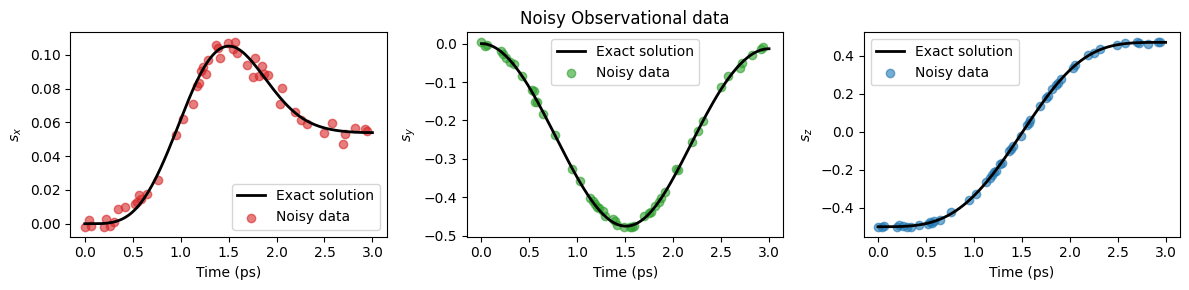

In [140]:
torch.manual_seed(2021)

t_intervals = 150
M = 50

# first, create some noisy observational data
t_test = torch.linspace(0,D,t_intervals).view(-1,1)
random_instances = torch.sort(torch.randperm(t_intervals)[:M]).values
t_obs = t_test[random_instances].view(-1,1)
sx_obs =  (torch.tensor(sx)[random_instances] + 0.004*torch.randn_like(t_obs).reshape(1,-1)).view(-1,1)
sy_obs =  (torch.tensor(sy)[random_instances] + 0.004*torch.randn_like(t_obs).reshape(1,-1)).view(-1,1)
sz_obs =  (torch.tensor(sz)[random_instances] + 0.004*torch.randn_like(t_obs).reshape(1,-1)).view(-1,1)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].plot(t_test[:,0], sx, label="Exact solution", color="black", linewidth=2)
axes[0].scatter(t_obs[:,0], sx_obs, label="Noisy data", alpha=0.6, color="tab:red")
axes[0].set_xlabel("Time (ps)")
axes[0].set_ylabel(r"$s_x$")
axes[0].legend()

axes[1].set_title('Noisy Observational data')
axes[1].plot(t_test[:,0], sy, label="Exact solution", color="black", linewidth=2)
axes[1].scatter(t_obs[:,0], sy_obs, label="Noisy data",alpha=0.6, color="tab:green")
axes[1].set_xlabel("Time (ps)")
axes[1].set_ylabel(r"$s_y$")
axes[1].legend()

axes[2].plot(t_test[:,0], sz, label="Exact solution", color="black", linewidth=2)
axes[2].scatter(t_obs[:,0], sz_obs, label="Noisy data",alpha=0.6, color="tab:blue")
axes[2].set_xlabel("Time (ps)")
axes[2].set_ylabel(r"$s_z$")
axes[2].legend()

plt.tight_layout()

plt.show()

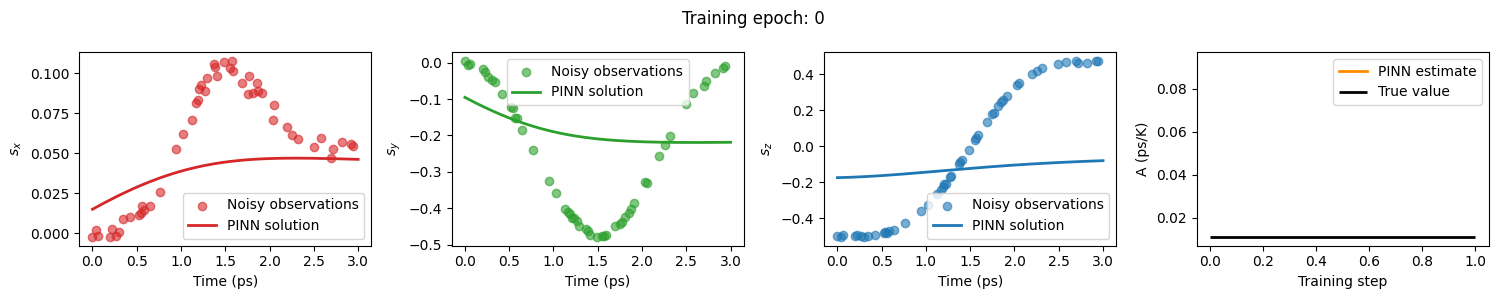

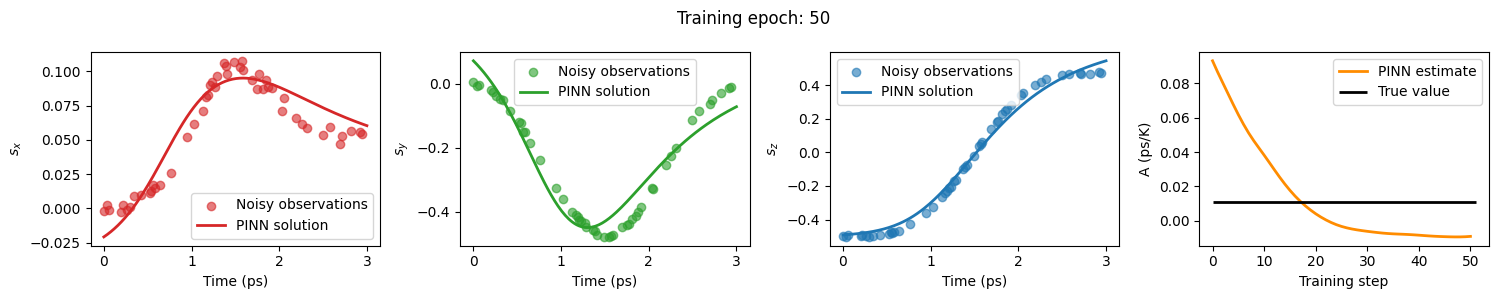

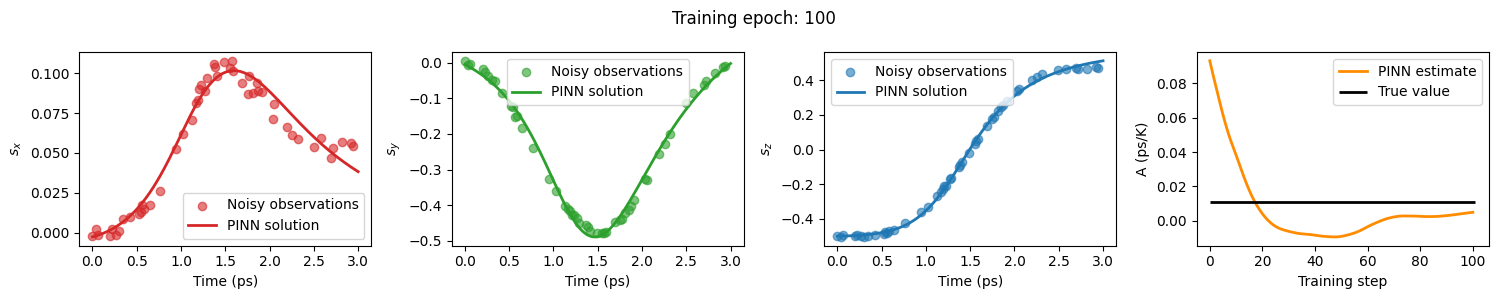

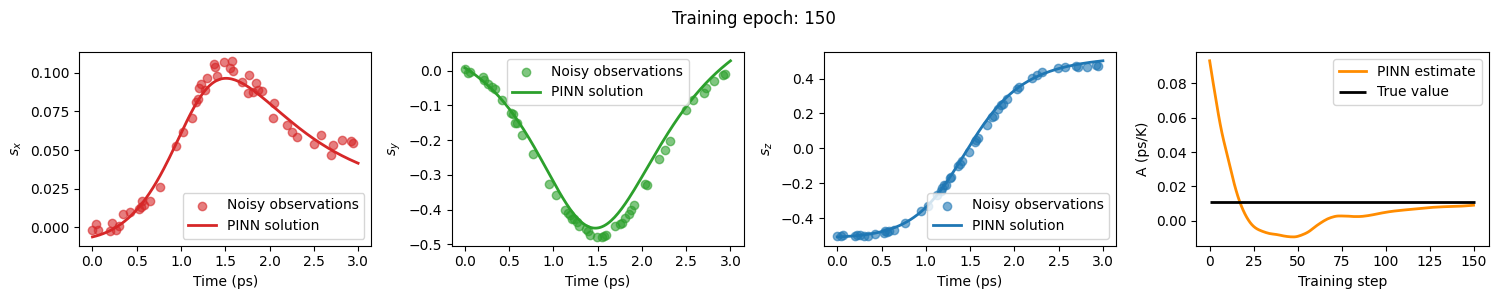

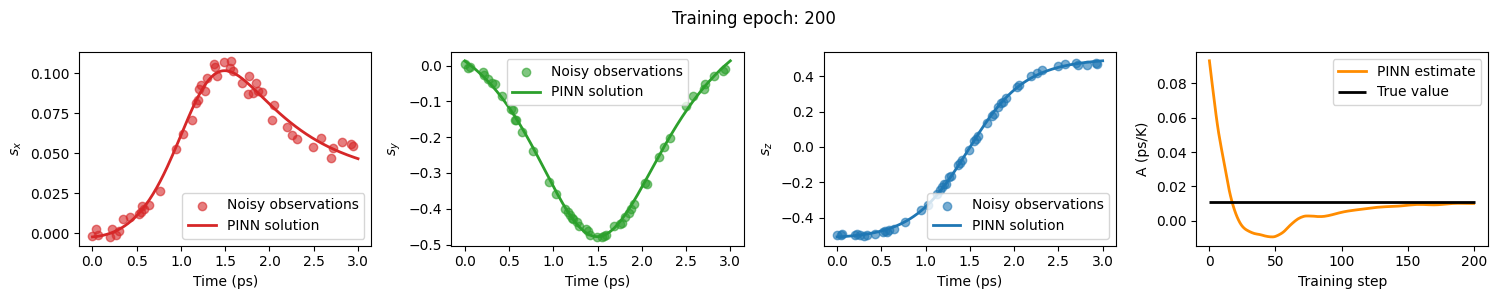

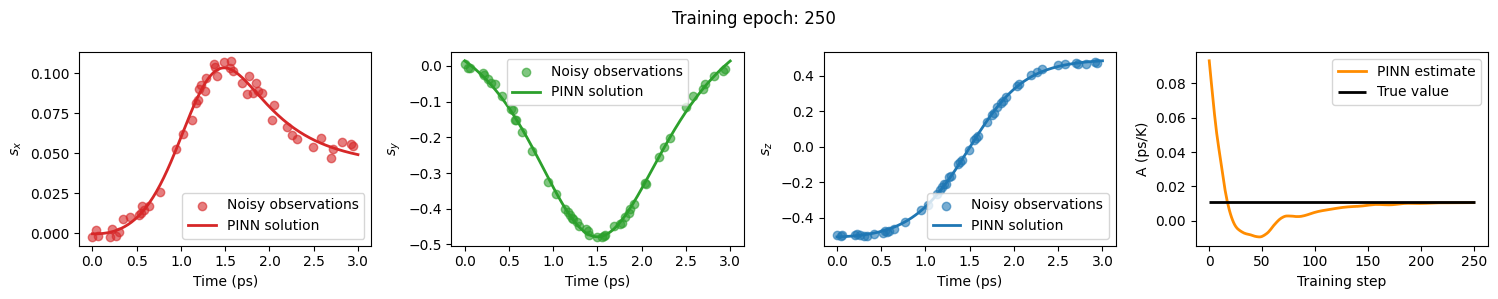

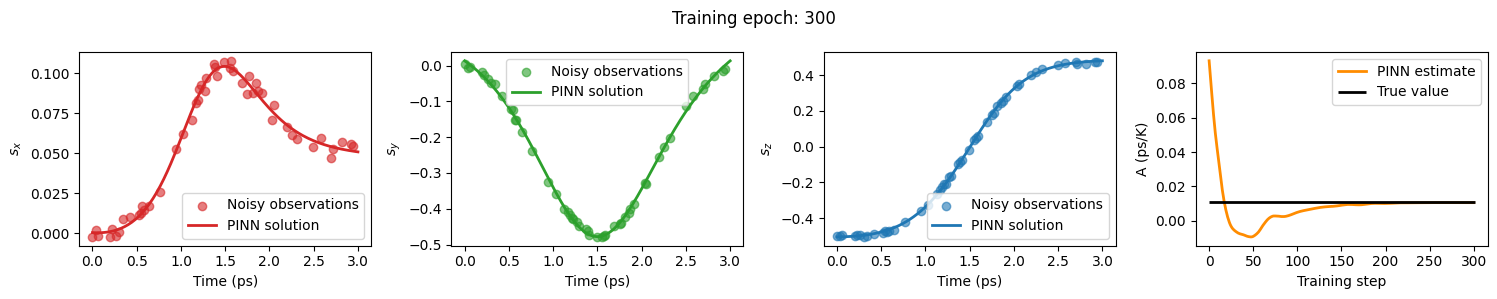

In [154]:
torch.manual_seed(2021)

# to avoid division by zero error
eps=1e-10

# define a neural network to train
pinn = FCN(1,3,32,4)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,D,t_intervals).view(-1,1).requires_grad_(True)#(t_intervals, 1)

# train the PINN
A0 = 0.0112     # ps/K

# treat coupling strength (A) as a learnable parameter, add it to optimiser
A = torch.nn.Parameter(0.1*torch.ones(1, requires_grad=True))

optimiser = torch.optim.Adam(list(pinn.parameters())+[A],lr=7e-3)
A_list = []


for i in range(301):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters
    lambda1 = 1e2

    # compute the coefficients
    rabi_list = rabi_freq(t=t_physics,D=D,Om_0=Om_0)
    detuning_list = detuning(t=t_physics,D=D,Om_0=Om_0)
    L_list = sqrt(rabi_list**2 + detuning_list**2) + eps
    theta_list = mixangle(t=t_physics,D=D)
    ga_list = phonon_abs(v=L_list, theta=theta_list, A=A)
    ge_list = phonon_emiss(v=L_list, theta=theta_list, A=A)

    # compute physics loss
    s_pred = pinn(t_physics)     # (t_intervals, 3)
    sx_pred, sy_pred, sz_pred = s_pred[:,0].view(-1,1), s_pred[:,1].view(-1,1), s_pred[:,2].view(-1,1)

    # compute gradients for sx, sy and sz
    dsx_dt = torch.autograd.grad(sx_pred, t_physics, torch.ones_like(sx_pred), create_graph=True)[0]        # (t_intervals, 1)
    dsy_dt = torch.autograd.grad(sy_pred, t_physics, torch.ones_like(sy_pred), create_graph=True)[0]        # (t_intervals, 1)
    dsz_dt = torch.autograd.grad(sz_pred, t_physics, torch.ones_like(sz_pred), create_graph=True)[0]        # (t_intervals, 1)

    # calculate loss from eq. 1
    loss_sx = torch.mean((dsx_dt + rabi_list*(ga_list-ge_list)/L_list + (detuning_list**2 + 2*rabi_list**2)*(ga_list+ge_list)*sx_pred/(2*L_list**2) + detuning_list*sy_pred - detuning_list*rabi_list*(ga_list+ge_list)*sz_pred/(2*L_list**2))**2)

    # calculate loss from eq. 2
    loss_sy = torch.mean((dsy_dt - detuning_list*sx_pred + (ga_list+ge_list)*sy_pred/2 - rabi_list*sz_pred)**2)

    # calculate loss from eq. 3
    loss_sz = torch.mean((dsz_dt - detuning_list*(ga_list-ge_list)/L_list - detuning_list*rabi_list*(ga_list+ge_list)*sx_pred/(2*L_list**2) + rabi_list*sy_pred + (2*detuning_list**2+rabi_list**2)*(ga_list+ge_list)*sz_pred/(2*L_list**2))**2)

    loss_p = torch.mean(loss_sx + loss_sy + loss_sz)
    #print('loss_p:',loss_p)

    # compute data loss
    s_obs_pred = pinn(t_obs)
    sx_obs_pred, sy_obs_pred, sz_obs_pred = s_obs_pred[:,0].view(-1,1), s_obs_pred[:,1].view(-1,1), s_obs_pred[:,2].view(-1,1)

    loss_d = torch.mean(torch.mean((sx_obs - sx_obs_pred)**2) + torch.mean((sy_obs - sy_obs_pred)**2) + torch.mean((sz_obs - sz_obs_pred)**2))
    #print('loss_d:',loss_d)

    # backpropagate joint loss, take optimiser step
    loss = loss_p + lambda1*loss_d
    #print('loss:',loss)
    loss.backward()
    optimiser.step()

    # record A values
    A_list.append(A.item())

    # plot the results as training progresses
    if i % 50 == 0:
        s = pinn(t_test).detach()

        fig, axes = plt.subplots(1, 4, figsize=(15, 3))
        fig.suptitle(f"Training epoch: {i}")

        axes[0].scatter(t_obs[:,0], sx_obs, label="Noisy observations", alpha=0.6, color="tab:red")
        axes[0].plot(t_test[:,0], s[:,0], label="PINN solution", color="tab:red", linewidth=2)
        axes[0].set_xlabel("Time (ps)")
        axes[0].set_ylabel(r"$s_x$")
        axes[0].legend()

        axes[1].scatter(t_obs[:,0], sy_obs, label="Noisy observations", alpha=0.6, color="tab:green")
        axes[1].plot(t_test[:,0], s[:,1], label="PINN solution", color="tab:green", linewidth=2)
        axes[1].set_xlabel("Time (ps)")
        axes[1].set_ylabel(r"$s_y$")
        axes[1].legend()

        axes[2].scatter(t_obs[:,0], sz_obs,label="Noisy observations", alpha=0.6, color="tab:blue")
        axes[2].plot(t_test[:,0], s[:,2], label="PINN solution", color="tab:blue", linewidth=2)
        axes[2].set_xlabel("Time (ps)")
        axes[2].set_ylabel(r"$s_z$")
        axes[2].legend()


        axes[3].plot(A_list, label="PINN estimate", color="darkorange",linewidth=2)
        axes[3].hlines(A0, 0, len(A_list), label="True value", color="black",linewidth=2)
        axes[3].set_ylabel(r"A (ps/K)")
        axes[3].set_xlabel("Training step")
        axes[3].legend()
        '''
        axes[4].plot(T_list, label="PINN estimate", color="deeppink")
        axes[4].hlines(T0, 0, len(T_list), label="True value", color="black")
        axes[4].set_ylabel("T (K)")
        axes[4].set_xlabel("Training step")
        axes[4].legend()
        '''
        plt.tight_layout()

        plt.show()
